# Ranking stocks

__Description__

На каждый день, мы имеем набор фич: среднее расстояние до target price из рекомендаций аналитиков, вышедших в течение последних 30 календарных дней (ra_factor), si_factor (текущий short interest), dividends yield, и доля в spx.

Исходя из этих факторов мы раз в N дней перерасчитываем ранжирующую модель. Наша цель - понять, какие из активов будут иметь взвешанную доходность выше остальных. Делаем мы это с помощью pair-wise перехода от задачи ранжирования к задаче классификации через Logistic Regression.

Итак, для на каждый конец дня мы получаем результат применения функции ранжирования к каждому из холдингов SPX. В базовом, подходе, мы берем top-k списка в лонг и bottom-k в шорт, каждую позицию с $$MarketValue = \frac{BP}{2k}$$

Чтобы описать итоговый подход, нужно сделать следующие уточнения:

* подход независимо отрабатывается в 6 секторах (в терминах bloomberg API: 'Consumer', 'Industrial', 'Communications' 'GICS_HealthCare', 'GICS_ConsumerDiscretionary', 'GICS_ConsumerStaples') 
* В каждом из секторов BP не статично, и вычисляется так: пусть Q_t это ряд std вектора функции ранжирования в день t, мы счиатем две SMA по этому ряду - Qfast, Qslow. Пусть $$q = \frac{Qfast-Qslow}{Qslow}$$, тогда наше BP в день t = BP_static *
$\gamma$. 

$$\gamma=round(MAX(0.5-MIN(q, 0.5), 0) * 10) / 10$$


* после входа в позицию мы не балансируем позицию, кроме как в случае изменения $\gamma$

__Детали реализации:__

Вектор фич:
    np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)
    
* **ra_factor** формируется, как и прежде: (см. spx_dataset/update_scripts/analyst_rec)

* **si_factor** формируется, как и прежде: (см. spx_dataset/update_scripts/SI&DIVY)

Это последнее известное отношение двух чисел 'SHORT_INT' / 'BS_SH_OUT' / 10^6 в терминах блумберга

* **div_yields** (см. spx_dataset/update_scripts/SI&DIVY)

Это field из блумберга **'EQY_DVD_YLD_12M'**(см. spx_dataset/update_scripts/SI&DIVY)

* **frac_factor** (см. spx_dataset/update_scripts/market_data_update)

Это отношение **'CUR_MKT_CAP'** компании к сумме **'CUR_MKT_CAP'** по всем, кто сейчас в **SPX**


__Journal of negative results__

Этот подход родился из скрещивания двух наших страых стратегий FT, FB после обнаружения  survival bias-а и того, как сильно он на них влияет. Опишу здесь какие улучшения предпринимались в рамках этого, подхода, чтобы его улучшить:

* is_factor - добавление в качестве фичи на каждый бар отношение Inventories growth к Sales growth.
* rec_label - добавление в качестве фичи на каждый бар процент рекомендации BUY, HOLD, SELL.
* соотношение скользящий средних и FIP, подсчитанных на ряде доли актива в SPX.
* relative scales - нормализовать вектор фичей сегодня на mean, std среди бумаг в рамках каждого дня.

In [1]:
# imports
%run ../modules/pnl_module.ipynb
%run ../modules/objectives_module.ipynb
%run ../modules/tools_module.ipynb

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '5972' (I am process '6448')


In [2]:
import pandas as pd
import datetime
import numpy.ma as ma
import tqdm
import glob
from sklearn.externals import joblib

### Data prepare

In [3]:
data_source = '../data/spx_dataset/'

In [4]:
gics_sectors_data = pd.read_csv(data_source+'gics_sectors.csv', usecols=['ISIN', 'sector'], index_col='ISIN')
sectors_data = pd.read_csv(data_source+'sectors.csv', usecols=['ISIN', 'sector'], index_col='ISIN')
all_sectors = set(sectors_data['sector'])
print('\nSECTOR NAMES:')
print(' '.join(map(str, all_sectors)))

all_gics_sectors = set(gics_sectors_data['sector'])
print('\nGICS SECTOR NAMES:')
print(' '.join(map(str, all_gics_sectors)))


SECTOR NAMES:
Communications Diversified Basic Materials Consumer Energy Industrial Utilities Technology Financial

GICS SECTOR NAMES:
nan Industrials Consumer Staples Real Estate Energy Utilities Financials Consumer Discretionary Information Technology Health Care Telecommunication Services Materials


In [161]:
# params
sector_need = 'GICS_Industrials'
#sector_sum = ['Industrial', 'Communications' ,\
#              'GICS_Consumer Staples', 'Utilities', 'GICS_Industrials']
START_DATE = datetime.datetime(2006, 1, 1)

In [162]:
if sector_need[:4] == 'GICS':
    sector = sector_need[5:]
    sector_subset = [sym for sym in sectors_data.index if gics_sectors_data['sector'].loc[sym] == sector] 
else:
    sector = sector_need
    sector_subset = [sym for sym in sectors_data.index if sectors_data['sector'].loc[sym] == sector] 

In [163]:
data_path = data_source+'{}.csv'
args = {'parse_dates' : ['Date'], 'index_col' : 'Date', 'usecols' : (['Date'] + sector_subset)}
sample_df = pd.read_csv(data_path.format('un_spx_daily_nonadjusted_close'), **args)
tickers, time_axis = sample_df.columns, sample_df.index

In [164]:
un_returns, un_a_pct_returns, un_na_price, in_spx_mask, un_a_price, si_factor, ra_factor, frac_factor, div_yields, is_factor=\
        map(lambda filename:\
        read_data(filename, args, start_idx=START_DATE),\
        map(lambda s: data_path.format(s), ['un_spx_adjusted_returns', 'un_spx_adjusted_pct_returns', \
                                            'un_spx_daily_nonadjusted_close', 'in_spx_mask',\
                                            'un_spx_daily_adjusted_close',\
         'Features/SI_FACTOR', 'Features/RA_FACTOR', 'Features/FRAC_FACTOR', 'Features/un_spx_div_yields',\
                                            'Features/SALINV_FACTOR']))

print('Shapes: {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(un_returns.shape, un_na_price.shape, un_a_price.shape,\
                in_spx_mask.shape, ra_factor.shape, si_factor.shape, frac_factor.shape, div_yields.shape, is_factor.shape))

Shapes: (2863, 79), (2863, 79), (2863, 79), (2863, 79), (2863, 79), (2863, 79), (2863, 79), (2863, 79), (2852, 79)


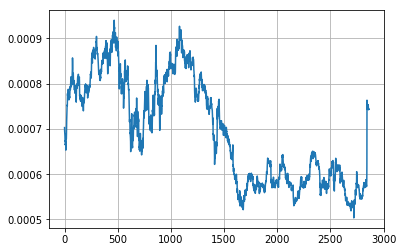

In [165]:
plt.plot(figsize=(12,8))
plt.grid()
plt.plot(frac_factor[:, np.random.randint(0, frac_factor.shape[1])])

In [166]:
si_factor = np.concatenate([np.repeat(np.nan, si_factor.shape[1])[np.newaxis, :], si_factor[1:]])

In [167]:
div_yields[np.isnan(div_yields)] = 0.

In [168]:
spy_pct_returns = read_data(data_path.format('spy_adjusted_percent_returns'), {'parse_dates' : ['Date'], 'index_col' : 'Date'}, START_DATE)
print('Shape: {}'.format(spy_pct_returns.shape))

Shape: (2863, 1)


In [169]:
time_axis

DatetimeIndex(['2006-01-04', '2006-01-05', '2006-01-06', '2006-01-09',
               '2006-01-10', '2006-01-11', '2006-01-12', '2006-01-13',
               '2006-01-17', '2006-01-18',
               ...
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18'],
              dtype='datetime64[ns]', name='Date', length=2863, freq=None)

In [170]:
mask = (np.isfinite(frac_factor) * \
        np.isfinite(si_factor) * np.isfinite(ra_factor) *\
        (in_spx_mask==1) * np.isfinite(un_na_price)).astype('bool')

anti_mask = (1-mask).astype('bool')

In [171]:
un_na_price[np.isnan(un_na_price)]=10**6
un_returns[np.isnan(un_returns)]=0

# fill factors with nan under mask
ra_factor[anti_mask]=np.nan
si_factor[anti_mask]=np.nan
div_yields[anti_mask] = np.nan
frac_factor[anti_mask] = np.nan
#is_factor[anti_mask] = np.nan

In [172]:

#for lab in recs_labels:
#    recs_features[lab][anti_mask] = np.nan
    
#rec_labels_dict = pd.read_csv('../data/spx_dataset/Features/recs_labels_dict.csv', sep=';')
#buy_labels = [lab.strip() for lab in list(rec_labels_dict['BUY'].dropna())]
#sell_labels = [lab.strip() for lab in list(rec_labels_dict['SELL'].dropna())]
#neutral_labels = [lab.strip() for lab in recs_labels if lab not in buy_labels and lab not in sell_labels]
#buy_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in buy_labels], axis=-1), axis=-1)
#sell_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in sell_labels], axis=-1), axis=-1)
#neutral_rec_factor = np.nansum(np.stack([recs_features[lab] for lab in neutral_labels], axis=-1), axis=-1)
#buy_rec_factor[anti_mask] = np.nan
#sell_rec_factor[anti_mask] = np.nan
#neutral_rec_factor[anti_mask] = np.nan


In [173]:
#div_yields, frac_factor = map(relative_scaler, (div_yields, frac_factor))

In [174]:
features_tensor = np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)
#features_tensor2 = np.stack([buy_rec_factor, sell_rec_factor, neutral_rec_factor], axis=-1)
#features_tensor2 /= (np.nansum(features_tensor, axis=-1, keepdims=True))
#features_tensor = np.concatenate([features_tensor, sectors_factor], axis=-1)
#features_tensor = np.concatenate([features_tensor, features_tensor2[:, :, :-1]], axis=-1)

In [175]:
features_tensor = np.stack([ra_factor, si_factor, div_yields, frac_factor], axis=-1)

In [176]:
FUTRET_WINDOW = 50
target = weighted_futret(un_a_pct_returns, FUTRET_WINDOW)
target[anti_mask]=np.nan

### Model (ranking)

In [177]:
OFFSET = FUTRET_WINDOW + 1
WINDOW_TRAIN = 1000
RETRAIN_FREQ = 25
SAMPLING_SIZE = 20 #round(target.shape[0]/3, 0)

In [178]:
features_tensor.shape, target.shape

((2863, 79, 4), (2863, 79))

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [180]:
def get_ranker(t, transformer=None):
    X, y = dinamic_train_cut(features_tensor, target, t, WINDOW_TRAIN, OFFSET)
    X_train, y_train = ranker_unpack(X, y, SAMPLING_SIZE)
    #print(X_train)
    if transformer:
        X_train = transformer.fit_transform(X_train)
    #mod = SVC(max_iter = 1000).fit(X_train, y_train)
    mod = LogisticRegression(C=1., penalty='l2').fit(X_train, y_train)
    return mod.decision_function, transformer.transform, mod

In [181]:
Q = np.empty(ra_factor.shape)
Q[:] = np.nan
start_t = OFFSET + WINDOW_TRAIN - 1
decision_fun, transform, mod_ = get_ranker(start_t, PolynomialFeatures(1, False, False))
#decision_fun, transform, mod_ = get_ranker(start_t, PolynomialFeatures(2))
for i in tqdm.tqdm(range(start_t, Q.shape[0])):
    if i % RETRAIN_FREQ == 0 or i == Q.shape[0]-1:
        decision_fun, transform, mod_ = get_ranker(i, PolynomialFeatures(1, False, False))
        #decision_fun, transform, mod_ = get_ranker(i, PolynomialFeatures(2))
        if i == Q.shape[0]-1:
            joblib.dump(mod_, '../realtime/{}.pkl'.format(sector_need))
    new_x = features_tensor[i, :, :]
    finite_idxs = np.where(np.isfinite(new_x).all(axis=1))[0]
    try:
        Q[i, finite_idxs] = decision_fun(transform(features_tensor[i, finite_idxs, :]) )  
    except:
        continue
        


100%|██████████████████████████████████████| 1813/1813 [00:16<00:00, 82.48it/s]


In [182]:
Q = np.where(np.isnan(Q), ma.array(Q, mask=np.isnan(Q)).mean(axis=1, keepdims=True), Q)  

### Backtest (ranking approach)

In [183]:
Q = Q[start_t:, :]
if un_na_price.shape[0] != Q.shape[0]:
    un_na_price, un_returns, mask, anti_mask = map(lambda df: df[start_t:,:], (un_na_price, un_returns, mask, anti_mask))

In [184]:
Q.shape, un_na_price.shape, mask.shape

((1813, 79), (1813, 79), (1813, 79))

In [185]:
_buying_power.set_value(10. ** 5)
_commis_per_share.set_value(0.01)
_nb_top.set_value(5)
_nb_bottom.set_value(5)

In [186]:
shares = quality_to_share_robust_fun(Q, un_na_price, mask)
shares = shares_norebalance(shares)

In [187]:
long_pos_count = (shares > 0).astype('float32').sum(axis=1)
short_pos_count = (shares < 0).astype('float32').sum(axis=1)
long_check = np.logical_or(long_pos_count == 0, long_pos_count == _nb_top.get_value()).all()
short_check = np.logical_or(short_pos_count == 0, short_pos_count == _nb_bottom.get_value()).all()
print('Robust matrix check pass: {}, {}'.format(long_check, short_check))

Robust matrix check pass: True, True


In [188]:
Q_ = np.copy(Q)
Q_[anti_mask] = np.nan

In [189]:
try:
    len(qual_range_data)
except NameError:
    qual_range_data = {}

In [190]:
qual_range = np.nanstd(Q_, axis=1)
qual_range_data[sector_need] = qual_range

qual_rolling_mean = np.nan_to_num(numpy_matrix_sma(qual_range.reshape(-1, 1), 250)).ravel()
qual_rolling_fast_mean = np.nan_to_num(numpy_matrix_sma(qual_range.reshape(-1, 1), 50)).ravel()

conf = ((qual_rolling_fast_mean - qual_rolling_mean) / qual_rolling_mean)
conf[np.isinf(conf)] = 0
conf[np.isnan(conf)] = 0
conf = np.maximum(0.5 - np.minimum(conf, 0.5), 0)
conf = np.floor(conf * 10)/10



#plt.figure(figsize=(10,6))
#plt.plot(qual_range)
#plt.plot(qual_rolling_mean)


#plt.figure(figsize=(10,6))
#plt.grid()
#plt.plot(conf)

In [191]:
shares2 = np.floor(shares * conf.reshape(-1, 1))

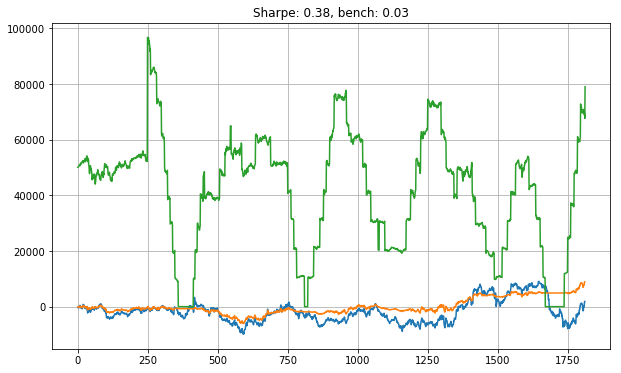

In [192]:
strategy_returns_arr = strategy_returns_fun(shares, un_returns)
strategy_returns_arr2 = strategy_returns_fun(shares2, un_returns)
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(strategy_returns_arr.cumsum())
plt.plot(strategy_returns_arr2.cumsum())

mval = market_value_fun(shares, un_na_price)
mval2 = market_value_fun(shares2, un_na_price)

#plt.plot(1000000 * qual_range)

#plt.plot(mval)
plt.plot(mval2)
plt.title('Sharpe: {}, bench: {}'.format(round(sharpe(strategy_returns_arr2), 2),\
                                        round(sharpe(strategy_returns_arr), 2)))

In [193]:
try:
    len(by_sector_ranking)
except NameError:
    by_sector_ranking = {}

In [194]:
by_sector_ranking[sector_need] = strategy_returns_arr
by_sector_ranking[sector_need+'with_conf'] = strategy_returns_arr2
by_sector_ranking[sector_need + 'mval'] = mval2

In [195]:
by_sector_ranking.keys()

dict_keys(['Industrial', 'Industrialwith_conf', 'Industrialmval', 'Communications', 'Communicationswith_conf', 'Communicationsmval', 'GICS_Consumer Staples', 'GICS_Consumer Stapleswith_conf', 'GICS_Consumer Staplesmval', 'Utilities', 'Utilitieswith_conf', 'Utilitiesmval', 'GICS_Industrials', 'GICS_Industrialswith_conf', 'GICS_Industrialsmval'])

In [196]:
sector_sum = ['Industrial', 'Communications' , 
              'GICS_Consumer Staples', 'Utilities', 'GICS_Industrials']

In [197]:
sector_need

'GICS_Industrials'

In [198]:
"""
sec = 'GICS_Industrials'
plt.figure(figsize=(15, 8))
plt.grid()

sum_pl = np.copy(by_sector_ranking[sec + 'with_conf']) / len(sector_sum)
plt.plot(by_sector_ranking[sec + 'with_conf'].cumsum(), '-', linewidth=1)
"""

"\nsec = 'GICS_Industrials'\nplt.figure(figsize=(15, 8))\nplt.grid()\n\nsum_pl = np.copy(by_sector_ranking[sec + 'with_conf']) / len(sector_sum)\nplt.plot(by_sector_ranking[sec + 'with_conf'].cumsum(), '-', linewidth=1)\n"

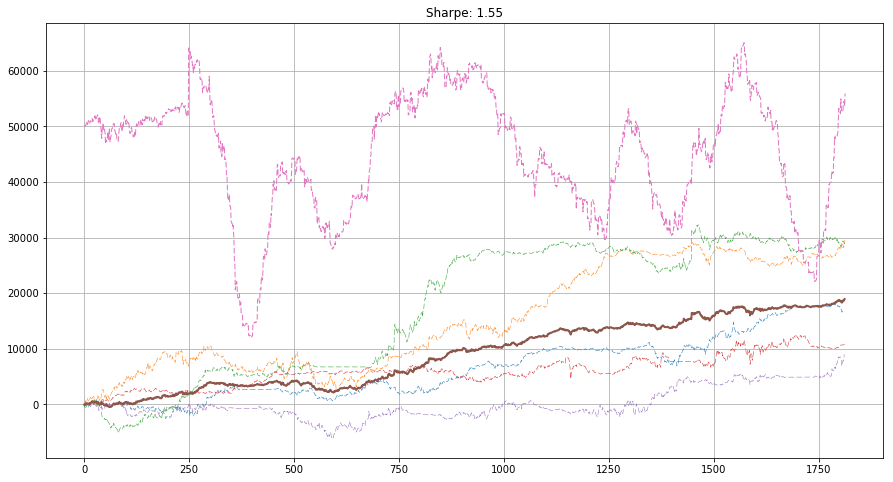

In [199]:
plt.figure(figsize=(15, 8))
plt.grid()

sum_pl = np.copy(by_sector_ranking[sector_sum[0] + 'with_conf']) / len(sector_sum)
sum_mval = np.copy(by_sector_ranking[sector_sum[0] + 'mval']) / len(sector_sum)
plt.plot(by_sector_ranking[sector_sum[0] + 'with_conf'].cumsum(), '--', linewidth=0.5)

for k in sector_sum[1:]:
    sum_pl += by_sector_ranking[k + 'with_conf'] / len(sector_sum)
    sum_mval += by_sector_ranking[k + 'mval'] / len(sector_sum)
    plt.plot(by_sector_ranking[k + 'with_conf'].cumsum(), '--', linewidth=0.5)

plt.plot((sum_pl).cumsum()[0:], linewidth=2)
plt.plot((sum_mval), '--', linewidth=1)
plt.title('Sharpe: {}'.format(round(sharpe(sum_pl), 2)))


In [200]:
LEVERAGE = 2.

In [201]:
sum_pl

array([ -56.85836,  -66.71824,   39.0169 , ...,   23.939  ,  156.061  ,
        167.72572])

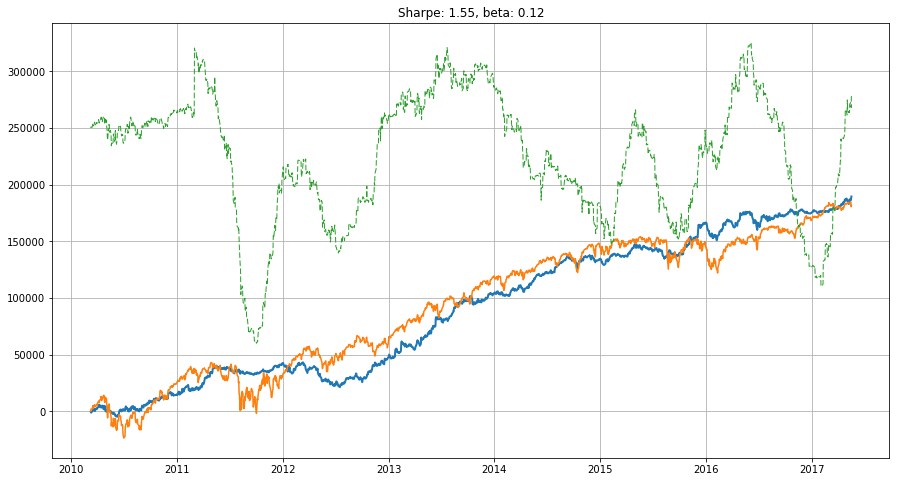

In [202]:
plt.figure(figsize=(15, 8))
plt.grid()

sum_pl = np.copy(by_sector_ranking[sector_sum[0] + 'with_conf'])
sum_mval = np.copy(by_sector_ranking[sector_sum[0] + 'mval']) 

for k in sector_sum[1:]:
    sum_pl += by_sector_ranking[k + 'with_conf']
    sum_mval += by_sector_ranking[k + 'mval'] 

benchmark_r =  np.mean(sum_mval) * spy_pct_returns[start_t:]
benchmark = benchmark_r.cumsum()
benchmark -= benchmark[0]

    
plt.plot(time_axis[(start_t+1):], (LEVERAGE * (sum_pl)).cumsum(), linewidth=2)
plt.plot(time_axis[(start_t):],  benchmark)
plt.plot(time_axis[(start_t):], (sum_mval), '--', linewidth=1)
plt.title('Sharpe: {}, beta: {}'.format(round(sharpe(sum_pl), 2),\
                                        round(np.corrcoef(benchmark_r[1:].ravel(), sum_pl * LEVERAGE)[0][1], 2)))


In [203]:
backtest = pd.DataFrame(np.hstack([sum_pl.reshape(-1,1), sum_mval[1:].reshape(-1,1), benchmark_r[1:]]),\
            index=time_axis[(start_t+1):])

In [204]:
backtest.columns = ['strategy_returns', 'margin', 'benchmark_returns']
backtest.index.name = 'Date'

In [214]:
backtest.to_csv('./pnls/ranker_backtest.csv')

In [215]:
sector_sum

['Industrial',
 'Communications',
 'GICS_Consumer Staples',
 'Utilities',
 'GICS_Industrials']

In [216]:
for sec in sector_sum:
    df = pd.DataFrame(qual_range_data[sec], index = time_axis[-qual_range_data[sec].shape[0]:])
    df.columns = ['Q_std']
    df.to_csv('../realtime/{}.csv'.format(sec))